# 1. Calculate various analytical solutions:

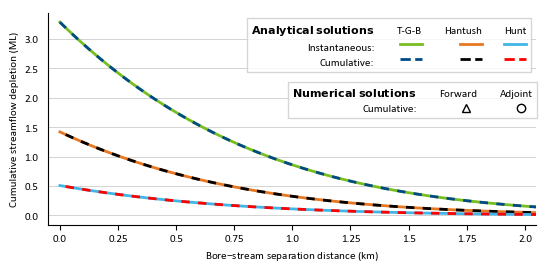

In [8]:
%matplotlib inline

#%% Import packages
import flopy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import erf, erfc, sqrt, pi, exp
from scipy.integrate import quad


#%% Define instantaneous T-G-B analytical solution (vector version)
def Theis1941GloverBalmer1954(Qw, R, t, S, T):
    D = []    
    for r in R:
        try:
            D.append(erfc(sqrt(((r**2.)*S)/(4.*T*t))))
        except:
            D.append(0.)
    return Qw*np.array(D)

#%% Define instantaneous T-G-B analytical solution (scalar version)
def Theis1941GloverBalmer1954_scalar(t, Qw, r, S, T):  
    return np.abs(Qw*erfc(sqrt(((r**2.)*S)/(4.*T*t))))

#%% Define cumulative T-G-B analytical solution (original version)
def AnderssenEtAl2017(Qw, R, t, S, T):
    D = []    
    for r in R:
        z = ((r**2.)*S)/(4.*T)
        try:
            D.append(t*erfc(sqrt(z/t))-sqrt(z/pi)*
                    (2.*((t*exp(-z/t)-sqrt(pi)*z*sqrt(t/z)*erfc(1./sqrt(t/z)))/
                    sqrt(t))))
        except:
            D.append(0.)
    return Qw*np.array(D)

#%% Define cumulative T-G-B analytical solution (alternative version)
def Cumulative_TGB(tau, Qw, b):
    return Qw*((2.*(b**2.)+tau)*erfc(b/sqrt(tau))-
              ((2.*b*sqrt(tau))/(sqrt(pi)*exp((b**2.)/tau))))

#%% Define instantaneous Hantush (1965) solution
def Hantush1965(t, x, T, S, L, Qw):
    try:
        RHS = (exp(((T*t)/((L**2.)*S))+(r/L))*
               erfc(sqrt( (T*t)/((L**2.)*S))+ 
                    sqrt(((r**2.)*S)/(4.*T*t))))  
    except:
        RHS = 0.
    D = np.abs(Qw)*(erfc(sqrt(((r**2.)*S)/(4.*T*t)))-RHS)
    return D

#%% Define instantaneous Hunt (1999) analytical solution
def Hunt99(t, x, T, S, lam, Qw):
    try:
        term1 = erfc(sqrt(((x**2.)*S)/(4.*T*t)))
    except:
        term1 = 0.
    try:
        term2 = exp((((lam**2.)*t)/(4.*S*T)) + ((lam*x)/(2.*T)))
    except:
        term2 = 0.
    try:
        term3 = erfc(sqrt(((lam**2.)*t)/(4.*S*T)) + sqrt(((x**2.)*S)/(4.*T*t)))
    except:
        term3 = 0.
    return Qw*(term1-term2*term3)

#%% Define cumulative Hunt (1999) analytical solution
def Cumulative_Hunt99(tau, Qw, a, b, c):
    d = (a**2.)*b
    try:
        h = (b*exp((a**2.)*tau+c))/d
    except:
        h = 0.
    try:
        h += (2.*a*b*exp(-b*(b+2.*a*tau)/tau+c)*sqrt(tau))/(d*sqrt(pi))
    except:
        pass
    try:
        h += -((b*exp(-2.*a*b+c))/d)
    except:
        pass
    try:
        h += -((2.*a*(b**2.)*exp(-2.*a*b+c))/d)
    except:
        pass
    try:
        h += (b*(1.+2.*a*b)*exp(-2.*a*b+c)*erf(b/sqrt(tau)))/d
    except:
        pass
    try:
        h += -((b*exp((a**2.)*tau+c)*erf((b+a*tau)/sqrt(tau)))/d)
    except:
        pass
    return Qw*h

#%% Define Matplotlib parameters
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['font.sans-serif' ] = 'Calibri'
mpl.rcParams['font.size'       ] = 8
mpl.rcParams['mathtext.default'] = 'regular'          
mpl.rcParams['xtick.direction' ] = 'out'
mpl.rcParams['ytick.direction' ] = 'out'       
mpl.rcParams['lines.linewidth' ] = 0.5      

#%% Define plot colours
c = np.array([(120., 190.,  32.), 
              (  0.,  75., 135.), 
              (255., 184.,  28.),
              ( 65., 182., 230.),
              (228.,   0.,  43.),
              (232., 119.,  34.),
              (255., 229., 177.)])/255.

#%% Define global parameters
FWDmodelname         = '05_Cumulative_depletion_Hunt_FWD'
ADJmodelname         = '05_Cumulative_depletion_Hunt_ADJ'
totim                = 365.
nlay, nrow, ncol     = 1, 100, 100
delr, delc, top, bot = 25., 25., 50., 0. # NOTE: 50 m thick, not 20 m
thk                  = top-bot
hk, vka, ss, sy      = 1.0, np.nan, np.nan, 0.02
tran                 = hk*thk
Kr, Br               = hk*1e-3, 1.
Lr, Wr               = delc, delr
stg, rbt, rcol       = top-5., bot, 0
rrows                = np.arange(nrow)
cnd                  = Kr*Wr*thk/Br
wrow, wflx           = nrow/2, -9. 
gamma, beta          = 10., 100.
loading              = 1.0*gamma+beta
wcols                = range(0, ncol, 10)[:5]

#%% Create output figure
f,s = plt.subplots(1,1, figsize=[16.00/2.54, 7.00/2.54])

#%% Calculate and plot numerical integration of instantaneous T-G-B solution
x = np.arange(0., ncol*delr+delr, delr)
N = []
for r in x:
    N.append(quad(Theis1941GloverBalmer1954_scalar, 0., totim, 
                  args=(wflx, r, sy, tran))[0])
TGBi, = s.plot(x, np.array(N)/1e3, '-', c=list(c[0]), lw=2.0)

#%% Calculate and plot cumulative T-G-B analytical solution
x = np.arange(0., ncol*delr+delr, delr)
N = []
for r in x:
    N.append(Cumulative_TGB(totim, -wflx, sqrt(((r**2.)*sy)/(4.*tran))))
TGBc, = s.plot(x, np.array(N)/1e3, '--', c=list(c[1]), lw=2.0, dashes=[3,3])

#%% Calculate and plot numerical integration of instantaneous Hantush solution
x = np.arange(0., ncol*delr+delr, delr)
N = []
L = hk*Br/Kr 
lam = 2.*tran/L
for r in x:
    N.append(quad(Hunt99, 0., totim, args=(r, tran, sy, lam, -wflx))[0])
Hani, = s.plot(x, np.array(N)/1e3, '-', c=list(c[5]), lw=2.0)

#%% Calculate and plot cumulative Hantush analytical solution
x = np.arange(0., ncol*delr+delr, delr)
tau = totim
T = tran
S = sy
Qw = -wflx
L = hk*Br/Kr 
lam = 2.*tran/L
a = sqrt((lam**2.)/(4.*S*T))
ch = []
for r in x:
    b = sqrt(((r**2.)*S)/(4.*T))
    C = (lam*r)/(2.*T)    
    ch.append(Cumulative_TGB(tau, Qw, b)-Cumulative_Hunt99(tau, Qw, a, b, C))
Hanc, = s.plot(x[1:], np.array(ch)[1:]/1e3, '--', c='k', lw=2.0, 
               dashes=[3,3])

#%% Calculate and plot numerical integration of instantaneous Hunt solution
x = np.arange(0., ncol*delr+delr, delr)
lam = Kr*Wr/Br 
N = []
for r in x:
    N.append(quad(Hunt99, 0., totim, args=(r, tran, sy, lam, -wflx))[0])
Huni, = s.plot(x, np.array(N)/1e3, '-', c=list(c[3]), lw=2.0) #,

#%% Calculate and plot cumulative Hunt analytical solution
x = np.arange(0., ncol*delr+delr, delr)
tau = totim
T = tran
S = sy
Qw = -wflx
lam = Kr*Wr/Br 
a = sqrt((lam**2.)/(4.*S*T))
ch = []
for r in x:
    b = sqrt(((r**2.)*S)/(4.*T))
    C = (lam*r)/(2.*T)    
    ch.append(Cumulative_TGB(tau, Qw, b)-Cumulative_Hunt99(tau, Qw, a, b, C))
Hunc, = s.plot(x[1:], np.array(ch)[1:]/1e3, '--', c='r', lw=2.0, dashes=[3,3])

#%% Create legend for analytical solutions
from matplotlib.lines import Line2D
blnk = plt.Rectangle((0, 0), 1, 1, fc='w', fill=False, ec='none', lw=0)

tgb_ni = Line2D([], [], ls='-',  c=c[0], lw=2.0)
han_ni = Line2D([], [], ls='-',  c=c[5], lw=2.0)
hun_ni = Line2D([], [], ls='-',  c=c[3], lw=2.0)

tgb_cf = Line2D([], [], ls='--', c=c[1], lw=2.0)
han_cf = Line2D([], [], ls='--', c='k',  lw=2.0)
hun_cf = Line2D([], [], ls='--', c='r',  lw=2.0)

handlesA = [blnk,  blnk,   blnk,
            blnk,  tgb_ni, tgb_cf,
            blnk,  han_ni, han_cf, 
            blnk,  hun_ni, hun_cf]
Lcol1A = [r'$\bfAnalytical$'+' '+r'$\bfsolutions$', 'Instantaneous:', 'Cumulative:']
Lcol2A = ['T-G-B',   '', '']
Lcol3A = ['Hantush', '', '']
Lcol4A = ['Hunt',    '', '']
labelsA = np.concatenate([Lcol1A, Lcol2A, Lcol3A, Lcol4A])
legendA = s.legend(handlesA, labelsA, loc=1, ncol=4, fancybox=False, 
                   markerfirst=False, handletextpad=-2)

#%% Create legend for numerical solutions        
num_fw = Line2D([], [], marker='^', c='none', ms=6, mec='k', mfc='none', mew=1.0)
num_ad = Line2D([], [], marker='o', c='none', ms=6, mfc='none', mec='k', mew=1.0)

handlesN = [blnk,  blnk,   
            blnk,  num_fw, 
            blnk,  num_ad]
Lcol1N = [r'$\bfNumerical$'+' '+r'$\bfsolutions$', 'Cumulative:']
Lcol2N = ['Forward', '']
Lcol3N = ['Adjoint', '']
labelsN = np.concatenate([Lcol1N, Lcol2N, Lcol3N])
legendN = s.legend(handlesN, labelsN, loc='upper left', ncol=3, fancybox=False, 
                   markerfirst=False, handletextpad=-2, 
                   bbox_to_anchor=[0.479, 0.700])
plt.gca().add_artist(legendA)

#%% Apply plot formatting
s.set_xlim(-50, 2050)
s.set_xticklabels(s.get_xticks()/1000.)
s.set_xlabel('Bore$-$stream separation distance (km)')
s.set_ylabel('Cumulative streamflow depletion (ML)')
s.xaxis.set_ticks_position('bottom')
s.yaxis.set_ticks_position('left')

for side in ['top', 'right']:
    s.spines[side].set_visible(False)
s.yaxis.set_ticks_position('none')
s.grid(which='major', axis='y', 
       c=(194./255., 194./255., 194./255.), ls='-', lw=0.5)

f

# 2. Run multiple numerical forward models:

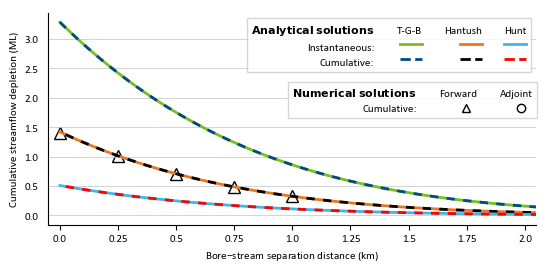

In [9]:
#%% Run zero extraction forward model
nper, perlen, nstp, stflag = 1, totim, int(totim), False

mf = flopy.modflow.Modflow(modelname=FWDmodelname, exe_name='../mf2005.exe')

flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, nper=nper,
                               delr=delr, delc=delc, top=top, botm=bot, 
                               steady=stflag, perlen=perlen, nstp=nstp)

ibound = np.ones([nlay, nrow, ncol], dtype=int)
strt = top*np.ones([nlay, nrow, ncol], dtype=float)
flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

flopy.modflow.ModflowBcf(mf, laycon=0, tran=tran, sf1=sy) 

spd = {}
lst = []
for rrow in rrows:
    lst.append([0, rrow, rcol, stg, cnd, rbt])
spd.update({0: lst})
flopy.modflow.ModflowRiv(mf, ipakcb=1, stress_period_data=spd) 

flopy.modflow.ModflowPcg(mf, hclose=1e-3, rclose=1e-3)

spd = {}
for ts in range(nstp):
    spd.update( {(0, ts): ['print head', 'save head', 'save budget']})
flopy.modflow.ModflowOc(mf, stress_period_data=spd)
    
mf.write_input()
success, buff = mf.run_model(silent=True)

flx = flopy.utils.binaryfile.CellBudgetFile(FWDmodelname+'.cbc')
flx = flx.get_data(text='   RIVER LEAKAGE', full3D=True)
#flx = np.array(flx)[-1,:,:,:]
#QRwp1 = np.ones(len(wcols))*np.abs(np.sum(-flx[-1,rrows,rcol]))
flx = np.array(flx)[:,0,rrows,rcol]
#QRwp1 = flx.sum()
QRwp1 = flx.sum()

#%% Run forward models for each bore-stream separation distance
QRwp2 = []
depl_FWD = []
wcs = range(ncol) 
x = np.arange(0, ncol)*delr
xw = x[wcols]
for i,wcol in enumerate(wcols):
    mf = flopy.modflow.Modflow(modelname=FWDmodelname, 
                               exe_name='../mf2005.exe')
    
    flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, nper=nper,
                             delr=delr, delc=delc, top=top, botm=bot, 
                             steady=stflag, perlen=perlen, nstp=nstp)
    
    ibound = np.ones([nlay, nrow, ncol], dtype=int)
    strt = top*np.ones([nlay, nrow, ncol], dtype=float)
    flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    
    flopy.modflow.ModflowBcf(mf, laycon=0, tran=tran, sf1=sy) 
    
    spd = {}
    lst = []
    for rrow in rrows:
        lst.append([0, rrow, rcol, stg, cnd, rbt])
    spd.update({0: lst})
    flopy.modflow.ModflowRiv(mf, ipakcb=1, stress_period_data=spd) 
    
    flopy.modflow.ModflowPcg(mf, hclose=1e-3, rclose=1e-3)
    
    spd = {}
    for ts in range(nstp):
        spd.update( {(0, ts): ['print head', 'save head', 'save budget']})
    flopy.modflow.ModflowOc(mf, stress_period_data=spd)
    
    spd = {0: [[0, wrow, wcol, wflx]]}
    flopy.modflow.ModflowWel(mf, stress_period_data=spd)
    
    mf.write_input()
    success, buff = mf.run_model(silent=True)
    
    flx = flopy.utils.binaryfile.CellBudgetFile(FWDmodelname+'.cbc')
    flx = flx.get_data(text='   RIVER LEAKAGE', full3D=True)
    flx = np.array(flx)[:,0,rrows,rcol]
    QRwp2.append(flx.sum())
    depl_FWD.append(abs(QRwp1-QRwp2[-1])/1000.)
    if i==0:
        lab='Numerical forward model solutions'
    else:
        lab='_no_label'
    s.plot(xw[i], depl_FWD[-1], '^', ms=8, mfc='none', mec='k', mew=1.0,
           label=lab, zorder=0)       

QRwp2 = np.array(QRwp2)
depl_FWD = np.array(depl_FWD)

f

# 3. Run a single numerical adjoint state model:

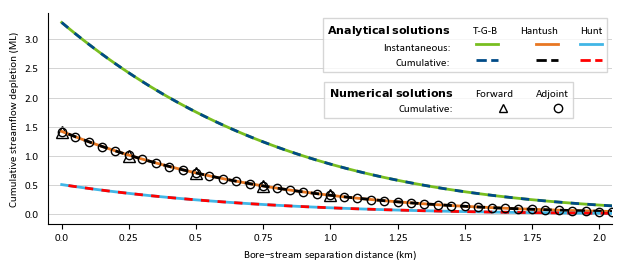

In [10]:
#%% Run single adjoint model
nstp_scalar = 1
mf = flopy.modflow.Modflow(modelname=ADJmodelname, exe_name='../mf2005.exe')

nper, perlen, nstp, stflag = 1, totim, int(totim), False

flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, nper=nper,
                         delr=delr, delc=delc, top=top, botm=bot, 
                         steady=stflag, perlen=perlen, nstp=nstp*nstp_scalar)
                                
ibound = np.ones([nlay, nrow, ncol], dtype=int)
ibound[0,  :, -1] = -1
strt = beta*np.ones([nlay, nrow, ncol], dtype=float)
strt[0, rrows, rcol] = cnd/delr/delc/sy*gamma+beta
flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

flopy.modflow.ModflowBcf(mf, laycon=0, tran=tran, sf1=sy) 

lst = []
for row in rrows:
    lst.append([0, row, rcol, loading, cnd, rbt])
spd = {0: lst}
flopy.modflow.ModflowRiv(mf, stress_period_data=spd) 

flopy.modflow.ModflowPcg(mf, hclose=1e-3, rclose=1e-3)

spd = {}
for ts in range(nstp):
    spd.update( {(0, ts): ['print head', 'save head', 'print budget', 
                           'save budget']})
flopy.modflow.ModflowOc(mf, stress_period_data=spd)
      
mf.write_input()
success, buff = mf.run_model(silent=True)

hds = flopy.utils.binaryfile.HeadFile(ADJmodelname+'.hds')
adj = hds.get_alldata()
adj = np.reshape(adj, [nstp, nrow, ncol])
adj = adj-beta
adj = adj/gamma/nstp_scalar
adjsum = adj.sum(axis=0)*abs(wflx)/1000.
hds.close()

x = np.arange(0, ncol)*delr
s.plot(x[::2], adjsum[wrow,:][::2], 'o', ms=6, mec='k', mfc='none', 
       mew=1.0, label='Numerical adjoint model solution')

#%% Remove Modflow input and output files
from os import getcwd, listdir, remove
for fn in listdir(getcwd()):
    if fn[-3:] in ['bas', 'bcf', 'cbc', 'dis', 'hds', 
                   'ist', 'nam', '.oc', 'pcg', 'riv', 'wel']:
        remove(fn)

#%% Apply plot formatting and finish
s.set_xlim(-50, 2050)
s.set_xticklabels(s.get_xticks()/1000.)

f.tight_layout()
f.savefig('05_Cumulative_depletion_Hunt_vs_FWD_vs_ADJ_v03_160519.png', dpi=500)
f